In [180]:
# jupyter notebooks cache imports, this is to ensure any changes to the
# custom modules are immediately loaded here.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
import pandas as pd
import numpy as np
import scipy as sp
import torch
import pathlib
from data_registry import RecordingRegistry
from dataset import HeartSoundDataset, get_dataloader
from signal_processor import SignalProcessor
import utils
from matplotlib import pyplot as plt

ROOT_DIR = "circor_data"

# Data Registry

- Class to handle loading the dataset.
- It creates the data labels, separates the recording locations, and segments the audio clips. 
- It doesn't actually load any audio clips.
- Outputs a dataframe where each row corresponds to one training example.

In a real world example using cloud resources, this is the module that would interact with the raw data store and load all available metadata from. 

For security reasons, it would be wise for the registry to also ensure the checksum hashes of the data files match and discard all data where it doesnt.

In [182]:
registry = RecordingRegistry(ROOT_DIR)
df = registry.load_data()
print(len(df))
df.head(5)

528


,Patient ID,Age,Sex,Height,Weight,Pregnancy status,MurmurType,RecordingLocation,InstanceID,AudioSegment,SegmentID,Uri
0,9979,Child,Female,103.0,13.1,False,Systolic,AV,0,"(6320, 66320)",0,circor_data/training_data/9979_AV.wav
1,9979,Child,Female,103.0,13.1,False,Systolic,PV,0,"(10512, 70512)",0,circor_data/training_data/9979_PV.wav
2,9979,Child,Female,103.0,13.1,False,Systolic,TV,0,"(15792, 75792)",0,circor_data/training_data/9979_TV.wav
3,9979,Child,Female,103.0,13.1,False,Systolic,MV,0,"(12304, 72304)",0,circor_data/training_data/9979_MV.wav
4,14241,Child,Male,87.0,11.2,False,Systolic,AV,0,"(10960, 70960)",0,circor_data/training_data/14241_AV.wav


In [183]:
# The doc string of the load_data function outlines the columns of the data loaded.
print(registry.load_data.__doc__)


        Loads the available data in two steps and returns a dataframe where each row is one
        training example, and contains an uri column to locate the raw audio file.
        First it loads the .csv file with all annotations and assigns MurmurType labels.
        Then it explodes such that each row is one training example by expanding along the
        recording location. Multiple signals from the same recording location are identified
        by `InstanceID`. It also segments audio clips into the segments of desired length.
        Each data point turns into (audio len // `segment_len`) data points after segmenting.

        Output dataframe columns:
            - 'Patient ID': string identifier of the subject being recorded
            - 'Age': categorical string. In ("Child", "Infant", "Adolescent", "Neonate")
            - 'Sex': categorical string. In ("Male", "Female")
            - 'Height': float. In centimeters.
            - 'Weight': float. In kilograms.
           

In [184]:
# It allows getting more data columns if available, and a different segment length if desired
df = registry.load_data(additional_cols=["Campaign", "Additional ID"], segment_len=10.0)
df.head(3)

,Patient ID,Age,Sex,Height,Weight,Pregnancy status,MurmurType,Campaign,Additional ID,RecordingLocation,InstanceID,AudioSegment,SegmentID,Uri
0,9979,Child,Female,103.0,13.1,False,Systolic,CC2015,NaN,AV,0,"(16320, 56320)",0,circor_data/training_data/9979_AV.wav
1,9979,Child,Female,103.0,13.1,False,Systolic,CC2015,NaN,PV,0,"(256, 40256)",0,circor_data/training_data/9979_PV.wav
2,9979,Child,Female,103.0,13.1,False,Systolic,CC2015,NaN,PV,0,"(40768, 80768)",1,circor_data/training_data/9979_PV.wav


In [185]:
# And throws an exception if you request a column that doesn't exist
# Comment out to see it
# df = registry.load_data(additional_cols=["ThisIsNotAColumn"])

In [186]:
# Back to the default dataset with no additional columns, at 15s segment length
# Make sure to click the `view as scrollable element` to see the value_counts
# in this curated dataset.
df = registry.load_data(segment_len=15.0)
categorical_cols = ["Age", "Sex", "Pregnancy status", "MurmurType", "RecordingLocation"]
for col in categorical_cols:
    print(f"----------------------------------------")
    print(df[col].value_counts())
    print(f"----------------------------------------")

----------------------------------------
Age
Child         394
Infant         57
Adolescent     49
Neonate         1
Name: count, dtype: int64
----------------------------------------
----------------------------------------
Sex
Female    269
Male      259
Name: count, dtype: int64
----------------------------------------
----------------------------------------
Pregnancy status
False    520
True       8
Name: count, dtype: int64
----------------------------------------
----------------------------------------
MurmurType
Systolic     515
Diastolic     13
Name: count, dtype: int64
----------------------------------------
----------------------------------------
RecordingLocation
MV     164
TV     130
PV     117
AV     114
Phc      3
Name: count, dtype: int64
----------------------------------------


# Signal Processing Module
For a batch of signals provided, 
- It bandpass filters the signal
- Then computes the spectrogram. 
- The operations are vectorized, and computed with scipy.signal.

**Implementation Notes on Package choice**
The data loader/dataset are pytorch modules. So everything outside Signal processing speaks torch.Tensor lingo. At scale, we would also want the signal processing to be done using pytorch to take advantage of gpu accelerations, but I found some parity issues between scipy and torch's filtering and spectrogram computations. Scipy's algorithms seem to be the more trusted one, so I implement them with scipy. This means turning the torch tensor into a numpy ndarray before preprocessing (cheap operation cause nothing moves in memory), then turning numpy ndarray back to torch tensor (which is more expensive because we have to copy the numpy array because torch is more strict about strides and the scipy signal processing modules seem to mess that up and torch doesn't like it).

**Notes from bandpass filter choice**
I went for a butterworth filter. From visual inspection of spectrograms, it seems the features that tell murmur apart from no murmur are in the 100s, so I assume that’s where the important information for classifying systolic vs. diastolic would be. Then we don’t necessarily care about the sharp rolloff of a chebyshev filter. So it made sense to prioritize a flatter response in the pass band. I used a butterworth filter of order 4. The order is somewhat arbitrary, I tried a few values and they didnt seem to change much at least visually.

**Notes from spectrogram parameters** 
Looking at the 4 cycles of heart sound, the stages of heart pumping (S1, S2, systole, diastole) cycle at something a bit less than 100 ms to a little over 150 ms per stage; let’s say lower bound is ~80ms for some margin. So, our time window must be shorter than that for the model to be able to distinguish different cycles which would very likely be important to eventually solve the classification problem. The lowest frequency we are looking at is 20 Hz, which is 1/20 = 0.05s = 50 ms, so our time window must be at least that long. Let’s say we need at least 60ms for some margin. I experimented with a few window sizes in the range of 60-80 ms and the spectrograms look similar visually. I noticed that for a 4000 Hz sampling frequency, a 64 ms window size gets us 256 samples; power of 2 looks very nice in our world of radix-2 algorithms (FFT works fastest on 2^k long inputs) and binary representations (for better cache utilization). I’m unsure if it actually matters today as the common algorithms are very optimized for modern hardware, but I decided to pick that time window for aesthetics. I also use a hamming window with 50% overlap for the spectrogram, and I also take a base-10 log of the spectrogram (PSD) before normalizing them.

**Scaling Up**
When we scale up, I can imagine the signal processing being an independent module. In the current implementation it's the main() function in data_loader.py, or one of the cells below in this notebook that calls preprocess after loading a dataset. For small scale datasets, which are common in early iterations of modeling, I think this may be preferred as it allows us to change parameters flexibly without having to either cache or save preprocessed samples and manage that in disk. For a large scale system however, it makes sense to preprocess the dataset in a single batch. We can fix the parameters then write a preprocessor_client.py script whose job is to get the dataframe containing all data from the registry, and submit the preprocessing job in batches to cloud resources alongside the SignalProcessor class which does the actual math. The operations within the class are vectorized to process multiple signals at a time. Connecting to the notes on package choice from above, if we have GPU resources, we would want to re-write the filtering and spectrogram in torch, which may involve a bit more involved implementation than simply calling an off-the-shelf function.

In [187]:
def get_data(patient_id, recording_location, segment_id):
    data_row = df.loc[  (df["Patient ID"] == patient_id) & 
                        (df["RecordingLocation"] == recording_location) & 
                        (df["SegmentID"] == segment_id) ]
    uri = data_row["Uri"].item()
    segment = data_row["AudioSegment"].item()
    return uri, segment
 
# diastolic: 85119 PV
# systolic: 85110 MV
uri_d, segment_d = get_data("85119", "PV", 0)
uri_s, segment_s = get_data("85110", "MV", 0)

labels = ("Diastolic", "Systolic")
uris = [uri_d, uri_s]
segments = [segment_d, segment_s]

X_t, fs = utils.load_audio_segments(uris, segments)
N = X_t.shape[-1]
t = torch.linspace(0, int(1/(1.0 * fs) * N), N)

print(t.shape, X_t.shape)


torch.Size([60000]) torch.Size([2, 60000])


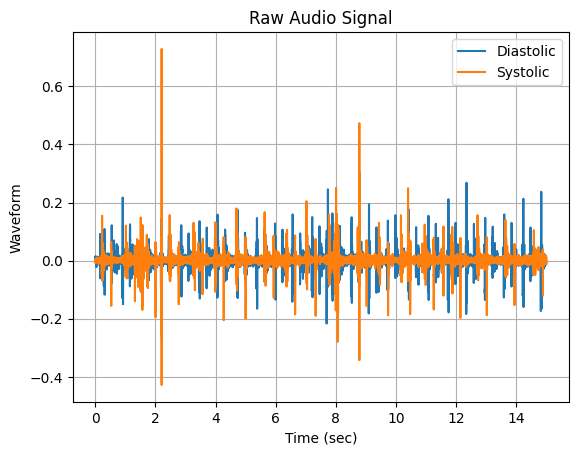

In [188]:
plt.plot(t, X_t[0], label=labels[0])
plt.plot(t, X_t[1], label=labels[1])
plt.grid()
plt.xlabel("Time (sec)")
plt.ylabel("Waveform")
plt.title("Raw Audio Signal")
plt.legend()

In [189]:
from signal_processor import SignalProcessor
signal_processor = SignalProcessor()
S_tf = signal_processor.prepare_training_examples(X_t)
t = signal_processor.t_axis(N)
f = signal_processor.f_axis()
print(S_tf.shape, t.shape, f.shape)

torch.Size([2, 129, 467]) torch.Size([467]) torch.Size([129])


In [190]:
def plot_spectrogram(batch_i):
    plt.figure(figsize=(18,5))
    plt.pcolormesh(t, f, S_tf[batch_i], cmap="viridis")
    plt.xlabel("Time (sec)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim(0, 1000)
    plt.title(f"{labels[batch_i]} Murmur Spectrogram")
    plt.colorbar()

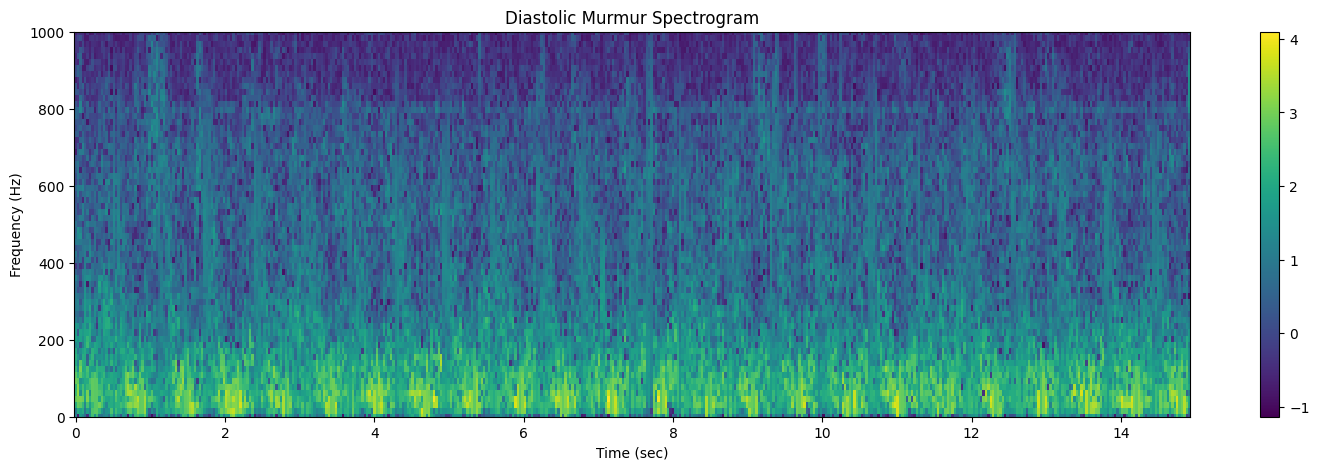

In [191]:
plot_spectrogram(0)

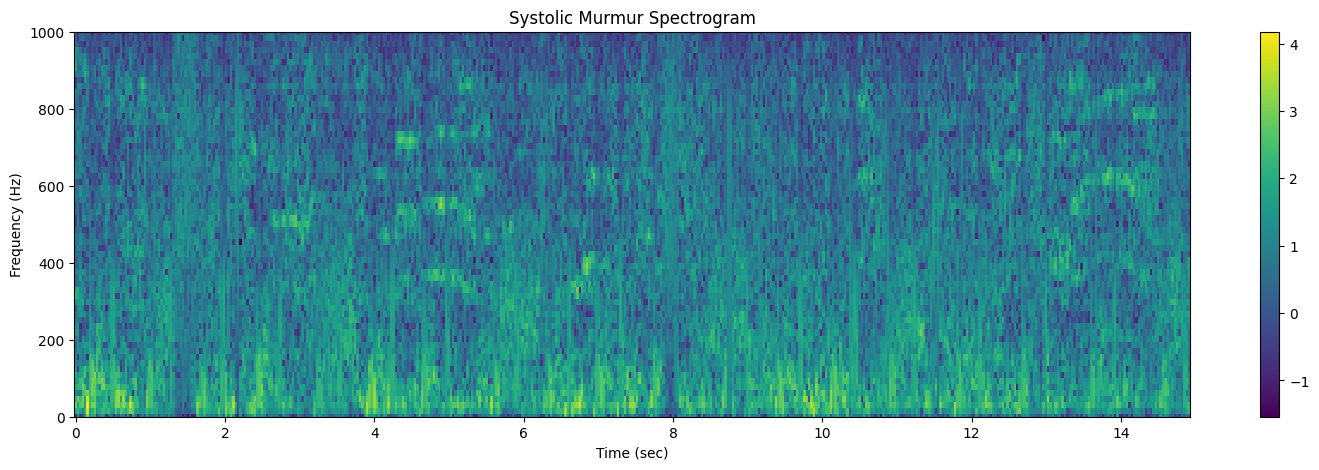

In [192]:
plot_spectrogram(1)

# Dataset

This class handles the management of the dataset. It receives the dataframe input from registry where one row corresponds to one data point. The __get_item__() function allows a pytorch dataloader to load data from this dataset. 


**Balanced Sampling**
A key feature of the dataset is the sampler, which allows a balanced sampling across imbalanced label and feature classes. This is done by assigning weights inversely proportional to the frequency of occurence of the features of interest. The weights are then passed into torch's WeightedRandomSampler to sample with this weighting. We can think of the weighting as assigning discrete probability values to each of the rows of the data point, turning it into a non-uniform probability distribution on the random variable = row of data. Rare classes will be sampled more often according to this probability distribution which will allow data loading without bias in the features we care about. The sampling is done with replacement (which means the sampler can draw each row multiple times) for this implementation because of the small nature of the dataset, but it can be done without replacement on large datasets where we are happy to throw away frequently occuring classes of data points but don't want to sample the same thing more than once.

This works well for categorical columns. And if there are multiple features we'd like to balance on we can concatenate them to create a joint-category and assign probability values to each row of inversely proportional to the frequencies of this new joint-category.

As for the numerical values of Height and Weight, a simple method to incorporate them is be to bin the values and treat them like categorical. I chose not to implement that for this submission.

**Scaling Up**
The dataset class doesn't do much heavylifting outside of loading the audio files. The sampler is initialized once, so the dataset only needs to compute the frequency of occurence of the features we care about once at the start of training. In a scaled up scenario, it would load the preprocessed spectrograms instead of the raw audio files. So it has to run in a compute cluster with fast access to the data store we choose to keep the preprocessed spectrograms in. The dataframe itself containing the features, annotations, and a pointer to the data filename is not expected to be too large, but if we do reach that scenario, spark is a natural tool to process very large dataframes and could be suitable for the task.

In [193]:
# example data, the dataset class itself doesnt do much without a dataloader
# which is why the get_dataloader function comes in the same file as the dataset.
dataset = HeartSoundDataset(df)
for i, (X_t, label, feature_dict) in enumerate(dataset):
    if i > 5:
        break
    print(f"Data point {i}...")
    print(f"\tWaveform shape: {X_t.shape}")
    print(f"\tLabel: {dataset.inverse_label_dict[label]}")

Loaded 528 training examples.
Data point 0...
	Waveform shape: torch.Size([60000])
	Label: Systolic
Data point 1...
	Waveform shape: torch.Size([60000])
	Label: Systolic
Data point 2...
	Waveform shape: torch.Size([60000])
	Label: Systolic
Data point 3...
	Waveform shape: torch.Size([60000])
	Label: Systolic
Data point 4...
	Waveform shape: torch.Size([60000])
	Label: Systolic
Data point 5...
	Waveform shape: torch.Size([60000])
	Label: Systolic


# Data Loader
This is the module that samples batches of data from the dataset. It's very tightly coupled with the dataset class and simply inherits from torch.utils.data.DataLoader. It has parameters that allow passing the balancing features to the dataset for sampling with weight. Batch size dictates the number of data point returned per iteration in a loop akin to `for data in dataloader:`. The num_workers parameter controls parallelism, especially useful when training on GPUs, to train on each batch independently. Fixing the seed parameter allows reproducibility.

The main.py script contains a sample use of dataloader in a training loop in the main() function: also pasted in the cell below. You should be able to set a balancing feature and get a summary count printed at the end of the training loop.

The dimension of the spectrogram is (batch size, n_frequency bins, n_time bins). 
Label is integer indicating Diastolic vs. Systolic murmur. dataset.inverse_label_dict

In [209]:
# Load the data curation modules
df = RecordingRegistry("circor_data").load_data()
dataset = HeartSoundDataset(df)
preprocessor = SignalProcessor()

# Get a data loader than samples without bias on Pregnancy status
# balance_on = ["Pregnancy status",]

# Get a data loader than samples without bias on label
# balance_on = ["MurmurType",]

# Balance on multiple features
balance_on = ["MurmurType", "Age", "Sex"]

dataloader = get_dataloader(
    dataset, 
    balance_on=balance_on, 
    batch_size=4, 
    seed=42
)

# Dictionary to count the features
feature_counts = {}
features_of_interest = balance_on
if "MurmurType" not in features_of_interest:
    features_of_interest.append("MurmurType")

# placeholder for a batch of spectrograms to plot
S_tf_random = None 
labels_random = None

# "Training" Loop
for i, batch_data in enumerate(dataloader):
    waveform, label, metadata = batch_data
    S_tf = preprocessor.prepare_training_examples(waveform)
    print(f"Batch {i}: Spectrogram shape = {S_tf.shape}, label shape: {label.shape}")
    for feature in features_of_interest:
        if feature not in feature_counts:
            feature_counts[feature] = {}
        for value in metadata[feature]:
            feature_counts[feature][value] = feature_counts[feature].get(value, 0) + 1
    
    if i % 10 == 0:
        print(f"Feature counts after batch {i}:", feature_counts)
        
    if S_tf_random is None and i % 21 == 0:
        S_tf_random = S_tf
        labels_random = label

print(f"Final:: Feature counts after batch {i}:", feature_counts)
print("DONE")
        

Loaded 528 training examples.
Batch 0: Spectrogram shape = torch.Size([4, 129, 467]), label shape: torch.Size([4])
Feature counts after batch 0: {'MurmurType': {'Systolic': 4}, 'Age': {'Adolescent': 3, 'Child': 1}, 'Sex': {'Female': 3, 'Male': 1}}
Batch 1: Spectrogram shape = torch.Size([4, 129, 467]), label shape: torch.Size([4])
Batch 2: Spectrogram shape = torch.Size([4, 129, 467]), label shape: torch.Size([4])
Batch 3: Spectrogram shape = torch.Size([4, 129, 467]), label shape: torch.Size([4])
Batch 4: Spectrogram shape = torch.Size([4, 129, 467]), label shape: torch.Size([4])
Batch 5: Spectrogram shape = torch.Size([4, 129, 467]), label shape: torch.Size([4])
Batch 6: Spectrogram shape = torch.Size([4, 129, 467]), label shape: torch.Size([4])
Batch 7: Spectrogram shape = torch.Size([4, 129, 467]), label shape: torch.Size([4])
Batch 8: Spectrogram shape = torch.Size([4, 129, 467]), label shape: torch.Size([4])
Batch 9: Spectrogram shape = torch.Size([4, 129, 467]), label shape: tor

In [210]:
def plot_spectrogram(t, f, S_tf, label):
    plt.figure(figsize=(18, 5))
    plt.pcolormesh(t, f, S_tf, cmap="viridis")
    plt.colorbar()
    plt.xlabel("Time (sec)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim(0, 1000)
    plt.title(f"MurmurType: {label}")
    plt.show()

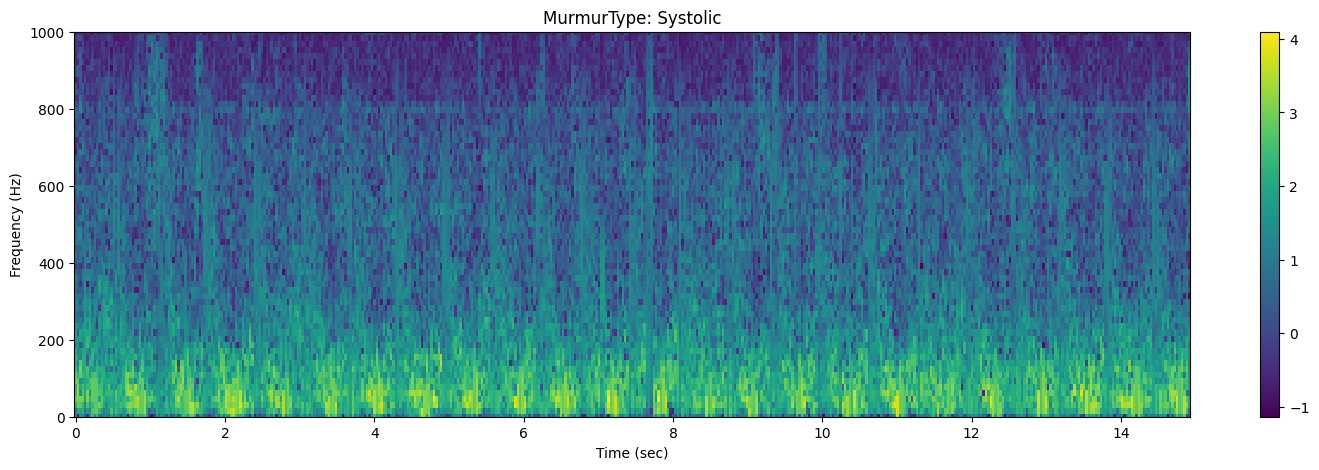

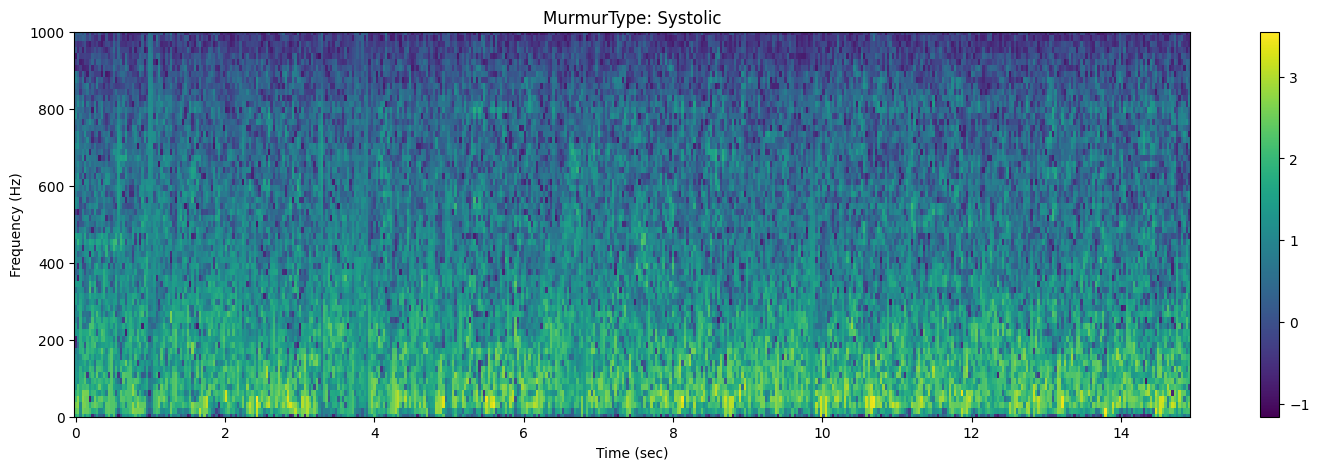

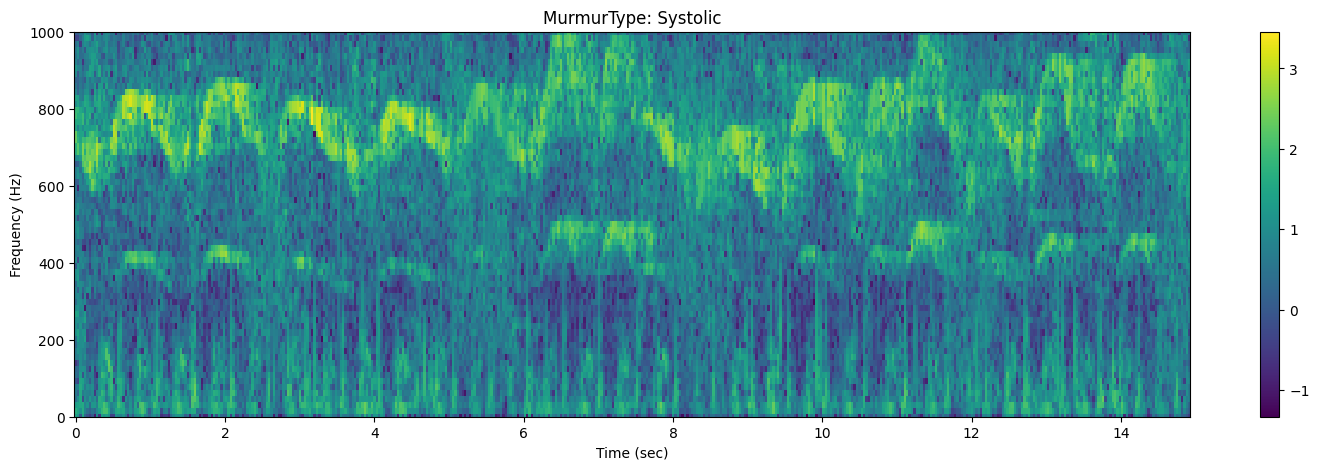

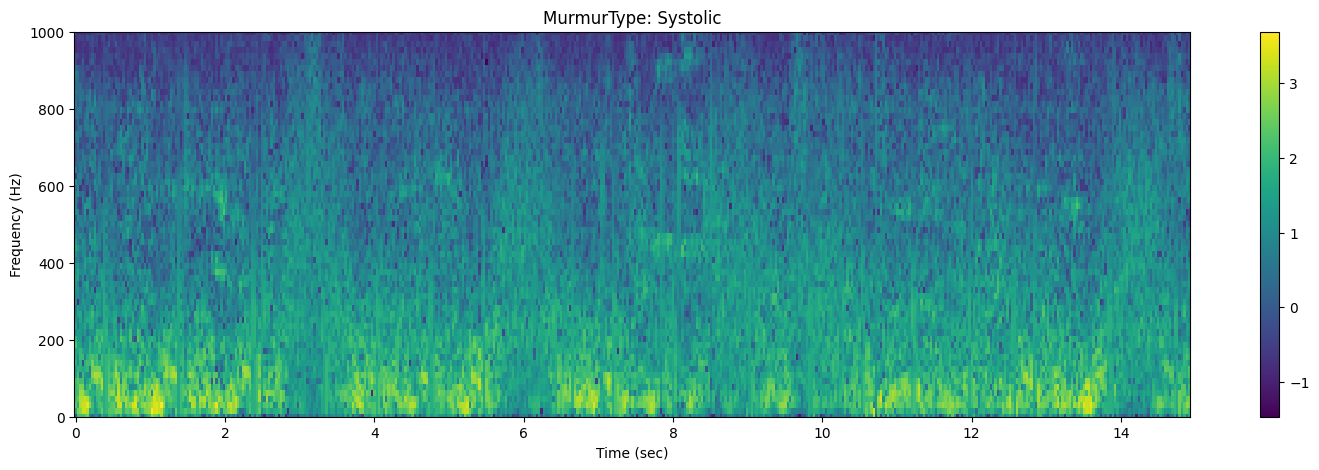

In [211]:
t = signal_processor.t_axis(6e4)
f = signal_processor.f_axis()
str_labels = [dataset.inverse_label_dict[l.item()] for l in labels_random]
for i in range(S_tf_random.shape[0]):
    plot_spectrogram(t, f, S_tf[i], str_labels[i])